# Adjacency Matrix 2.0

In [1]:
## setup

# from collections import defaultdict
from getpass import getpass
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import pymysql
import regex as re
import seaborn as sb
# from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Run these imports to skip the data import connector and pre-processing sections
Uncomment as needed

In [7]:
## to save time and not re-run the established portions of this notebook

## import saved csv
ingredients = pd.read_csv(os.getcwd()+'/offline/ingredients.csv')
display(ingredients.head(2))

## import the cleaned dataframe pickle files
ingredients_to_rids_df = pd.read_pickle(os.getcwd()+'/offline/ingredients_to_rids.pkl')
display(ingredients_to_rids_df.head(2))
rids_clean_ingredients_df = pd.read_pickle(os.getcwd()+'/offline/rids_clean_ingredients.pkl')
display(rids_clean_ingredients_df.head(2))

## import the matrix pickle files
with open(os.getcwd()+'/offline/edges.pickle', 'rb') as handle:
    edges_pickle = pickle.load(handle)
with open(os.getcwd()+'/offline/weights.pickle', 'rb') as handle:
    weights_pickle = pickle.load(handle)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,RECIPE_ID,MEASUREMENT,INGREDIENT
0,10000,3 cups,all-purpose flour
1,100008,8 ounces,"fresh young ginger root, peeled"


,RECIPE_ID
INGREDIENT,
sugar,"[10006, 10009, 10023, 10024, 10027, 100321, 10..."
salt,"[10028, 10059, 10066, 10072, 10085, 10109, 102..."


,INGREDIENT
RECIPE_ID,
10000,[milk]
100008,[sugar]


## Connect to database for data import
Run this section if not importing the .csv from the offline folder or to get a new set from the db.

In [3]:
## get login info
u = input("Enter username: ")
p = getpass("Enter password: ")

Enter username: recipator
Enter password: ········


In [4]:
## Function to import each table
def retrieveTable(query):
    db_conn = pymysql.connect(
        user = u,
        password = p,
        host = "recipatornew.mysql.database.azure.com",
        port = 3306,
        db = "recipator_db",
        ssl_ca = "C://Users//KAA//austinka//GT//CSE6242 DVA//Project//DigiCertGlobalRootCA.crt.pem",
        ssl_disabled = False)
    table = pd.read_sql(query,db_conn)
    db_conn.close() # ALWAYS close the connection
    return table

In [5]:
## import ingredients table (was recipator_db.model_ingredients)
import_ingr = '''
    SELECT *
    FROM recipator_db.model_ingredients
'''

ingredients = retrieveTable(import_ingr)

# ingredients = pd.DataFrame(results)
display(ingredients.head())
ingredients.info()

,RECIPE_ID,MEASUREMENT,INGREDIENT
0,10000,3 cups,all-purpose flour
1,100008,8 ounces,"fresh young ginger root, peeled"
2,10001,4,eggs
3,100011,2 tablespoons,vegetable oil
4,10002,½ teaspoon,"Salt, table"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232731 entries, 0 to 1232730
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   RECIPE_ID    1232731 non-null  object
 1   MEASUREMENT  1232731 non-null  object
 2   INGREDIENT   1232731 non-null  object
dtypes: object(3)
memory usage: 28.2+ MB


## Save files for OFFLINE WORK
Uncomment as needed

In [6]:
## save to csv for working offline
# ingredients.to_csv(os.getcwd()+'/offline/ingredients.csv', index=False)
# main.to_csv(os.getcwd()+'/offline/main.csv', index=False)
# subs.to_csv(os.getcwd()+'/offline/subs.csv', index=False)

## Clean and count the ingredients

In [5]:
## make a custom stopwords list
## removing status of ingredient words, example (frozen, diced)
## removing adjectives, example (color, dry)
## only put in words that are 3 or more characters, as the code
## removes smaller words (2 chars or less) later
custom_stopwords = ['chopped','and','fresh','ground','white',
                    'sliced','minced','dried','optional','table',
                    'green','diced','shredded','red','drained',
                    'into','peeled','cut','brown','black',
                    'large','softened','frozen','grated','dry',
                    'house','firmly','skim','whole','all-purpose',
                    'dry','mix','melted','beaten','finely','yellow',
                    'cubed','cooked','medium','small','sauce',
                    'crushed','divided','thinly','boneless',
                    'bell','thawed','pieces','cubes','crust',
                    'light','save','follows','hearty','layered',
                    'pan-frying','good-quality','express','skinless',
                    'inch','heirloom','1/2"','rectangular','solid-pack',
                    'fiber','julienne-cut','2-1/2','colossal','tsp',
                    'equivalent','teaspoons','tub-style','southwest',
                    'flanken','outer','least','secret','yields',
                    'well-beaten','dente','','multi-colored','major',
                    'mrs','simply','racks','aisle','working',
                    'untrimmed','excuding','packed','circles','pick',
                    'carb','parboiled','pfs','pad','family-sized',
                    'lbs','meet','digestion','tbsp','leaves',
                    'bdg','national','arm','fairly','microwaved',
                    'diluted','starbucks','mist','lots','full-bodied',
                    'shape','shred','-in','shape','corkscrew','sun-dried',
                    'grate','-inch','per','washing','mist','toothpick',
                    'colour','canister','grillers','kerrygold','wish-bone',
                    'unripe','tempura','pre-packaged','tasting','hugs',
                    'except','fast-rising','length-wise','delightfulls',
                    'handfull','frying','<sup>&reg<sup>otel<sup>&reg<sup>','loose-pack',
                    'tight','dissolve','purpose',
                    'young', 'table', 'whites', 'halved', 'tenderloin', # PL start
                    'seedless', 'toasted', 'lean', 'self-rising', 'plain',
                    'sifted', 'skinned', 'unsalted', 'pre-washed', 'box',
                    'boxes', 'squares', 'unsweetened', 'irish', 'flavored',
                    'pink', 'ripe', 'pureed', 'spears', 'bottle', 'colored',
                    'bone-less', 'bob', 'evans®', 'removed', 'tops', 'and', 'squeezed',
                    'italian', 'zesty', 'hot', 'canadian', 'slightly', 'taste',
                    'meat', 'prepared', 'candy-coated', 'slices', 'firm', 'smooth',
                    'flank', 'thinly', 'aged', 'chunks', 'dice', 'trimmed', 'dark',
                    'crumbs', 'pitted', 'room', 'temperature', 'deveined', 'portobello',
                    'caps', 'pre-baked', 'such', 'boboli', 'low-sodium', 'instant', 'active',
                    'dry', 'bittersweet', 'rolled', 'semisweet', 'chips', 'canned', 'make',
                    'ahead', 'mix', 'jigger', 'split', 'roast', 'thick', 'chops', 'center',
                    'loin', 'cutlets', 'about', 'butt', 'bone-in', 'freshly', 'picked',
                    'gluten-free', 'vanilla-flavored', 'buckwheat', 'kraft', 'uncooked',
                    'russet', 'rinsed', 'serving', 'style', 'cans', 'halves', 'jumbo',
                    'confectioners', 'seeded', 'chuck', 'sweetened', 'casings', 'crumbled',
                    'quartered', 'soft', 'very', 'coarsely', 'cooled', 'pounded',
                    'even', 'thickness', 'whole-grain', 'head', 'broken', 'loosely',
                    'reduced-sodium', 'cored', 'florets', 'tails', 'containers',
                    'refrigerated', 'non-fat', 'cloves', 'hulled', 'salted', 'strips',
                    'shelled', 'shoulder', 'korean', 'chinese', 'gluten', 'free', 'round',
                    'raw', 'sirloin', 'asian', 'fillets', 'filet', 'basmati', 'warm', 'tips',
                    'liquid', 'picnic', 'belly', 'stale', 'skewers', 'pressed', 'crispy',
                    'quick', 'quick-cooking', 'torn', 'bite', 'size', 'bite-size', 'washed',
                    'blanched'
                   ]

for w in custom_stopwords:
    STOPWORDS.add(w)
print('There are',len(STOPWORDS),'stopwords.')

There are 476 stopwords.


In [6]:
## strip the phrases and parse the words
words_sets = ingredients["INGREDIENT"].str.split(' ').apply(lambda x: [re.sub('[,™()®;\*:.!?\'0-9#\/]','',n.strip().lower()) for n in x]).tolist()
nwords = len(words_sets)
print('Sample of word sets:\n',words_sets[:5])

Sample of word sets:
 [['all-purpose', 'flour'], ['fresh', 'young', 'ginger', 'root', 'peeled'], ['eggs'], ['vegetable', 'oil'], ['salt', 'table']]


In [7]:
## make a set of cleaned words and count frequency
## full file count is millions of words before checking for duplicates
words = []
frequency = {}
word_count = 0
supressed = 0
for n in words_sets:
    for w in n:
        word_count +=1
        if w not in words and w not in STOPWORDS and len(w) > 2:
            words.append(w)
            frequency[w] = 1
        elif w in STOPWORDS or len(w) <= 2:
            supressed +=1
            pass
        elif w in words:
            frequency[w] +=1
        else:
            supressed +=1

print('There are',nwords,'ingredients listed having a total of',word_count,'words.')
print(len(words), 'unique words and', supressed, 'words supressed. That is', round(100*(supressed)/word_count,2),'% reduction!')

There are 1232731 ingredients listed having a total of 1647084 words.
23741 unique words and 1623343 words supressed. That is 98.56 % reduction!


In [8]:
## sort the list by frequency and remove words with extremely low frequency
minfreq = 10

freq_df = pd.DataFrame(frequency,index=[0]).transpose().sort_values(0,ascending=False)
freq_df = freq_df.drop(freq_df[freq_df[0] <= minfreq].index)
freq_df.rename({0:'frequency'},axis=1,inplace=True)

print('There are',len(freq_df), 'words with at least', minfreq+1, 'connections, which is an overall', round(100*(nwords-len(freq_df))/nwords,2),'% reduction')
print('\n\ntop of df\n',freq_df.head(5))
print('\nbottom of df\n',freq_df.tail(5))

There are 3789 words with at least 11 connections, which is an overall 99.69 % reduction


top of df
         frequency
sugar       63373
salt        55926
pepper      50418
butter      49979
oil         46891

bottom of df
            frequency
tight             11
handfull          11
dissolve          11
maca              11
tanqueray         11


In [71]:
## map the ingredients to sets of recipes that use them
ingredients_to_rids = {}

for i in freq_df.index:
    rids = []
    for row in ingredients.itertuples(index=False):
        if i in row[2]: # 'INGREDIENTS'
            rids.append(row[0]) # 'RECIPE_ID'
    ingredients_to_rids[i] = rids
ingredients_to_rids_df = pd.DataFrame(ingredients_to_rids.items(),columns=['INGREDIENT','RECIPE_ID'])
    
print('length of ingredients_to_rids',len(ingredients_to_rids))
print('example of this data: number of recipes that include cumin:',len(ingredients_to_rids['cumin']))
display(ingredients_to_rids_df.head())

length of ingredients_to_rids 3789
example of this data: number of recipes that include cumin 6418


,INGREDIENT,RECIPE_ID
0,sugar,"[10006, 10009, 10023, 10024, 10027, 100321, 10..."
1,salt,"[10028, 10059, 10066, 10072, 10085, 10109, 102..."
2,pepper,"[100056, 100289, 100493, 101475, 102910, 10440..."
3,butter,"[10003, 10008, 100084, 10010, 10011, 10015, 10..."
4,oil,"[100011, 100218, 100292, 100631, 100705, 10072..."


In [74]:
## set the ingredient as the index for future iteration
ingredients_to_rids_df.set_index('INGREDIENT', inplace=True)
# ingredients_to_rids_df.drop('Unnamed: 0',axis=1,inplace=True)
display(ingredients_to_rids_df.head())

,RECIPE_ID
INGREDIENT,
sugar,"[10006, 10009, 10023, 10024, 10027, 100321, 10..."
salt,"[10028, 10059, 10066, 10072, 10085, 10109, 102..."
pepper,"[100056, 100289, 100493, 101475, 102910, 10440..."
butter,"[10003, 10008, 100084, 10010, 10011, 10015, 10..."
oil,"[100011, 100218, 100292, 100631, 100705, 10072..."


In [9]:
## find the recipes that contain these new cleaned words
rids_clean_ingredients = {}

for row in ingredients.itertuples(index=False):
    ings = []
    for i in freq_df.index:
        if i in row[2]: # 'INGREDIENTS'
            ings.append(i) # this is for the dictionary method
    rids_clean_ingredients[row[0]] = ings
rids_clean_ingredients_df = pd.DataFrame(rids_clean_ingredients.items(),columns=['RECIPE_ID','INGREDIENT'])
    
print('length of rids_clean_ingredients',len(rids_clean_ingredients))
display(rids_clean_ingredients_df.head())

length of rids_clean_ingredients 140657


,RECIPE_ID,INGREDIENT
0,10000,[milk]
1,100008,[sugar]
2,10001,"[flour, purpose]"
3,100011,"[bay, leave, lea]"
4,10002,"[soy, use, seed, old, bean, see, soybean, hydr..."
...,...,...
140652,9997,"[sugar, one, con, ner, confectioner]"
140653,99970,[cheese]
140654,9998,[egg]
140655,99985,"[oil, canola, frying, fry]"


In [76]:
## set the recipe_id as the index for future iteration
rids_clean_ingredients_df.set_index('RECIPE_ID', inplace=True)
# rids_clean_ingredients_df.drop('Unnamed: 0',axis=1,inplace=True)
display(rids_clean_ingredients_df.head())

,INGREDIENT
RECIPE_ID,
10000,[milk]
100008,[sugar]
10001,"[flour, purpose]"
100011,"[bay, leave, lea]"
10002,"[soy, use, seed, old, bean, see, soybean, hydr..."


## Save files for OFFLINE WORK
Uncomment as needed

In [18]:
## save to pickle so that the list saves as list, not string
ingredients_to_rids_df.to_pickle(os.getcwd()+'/offline/ingredients_to_rids.pkl')
rids_clean_ingredients_df.to_pickle(os.getcwd()+'/offline/rids_clean_ingredients.pkl')

## Matrix build 2.0
build from the ingredients to rids map

In [11]:
## build the edges
edges = {}
weights = {}

for ingr,list_of_rids in ingredients_to_rids_df.iterrows():
    list_of_rids = list_of_rids[0]
    n = len(list_of_rids)
    if n > 25000:
        # print some of the ingredients to check progress of loop
        print(ingr,':',n),
    while n > 1:
        n = n-1 # minus one at beginning of loop to correct for indexing beginning at 0
        if (list_of_rids[n],list_of_rids[n-1]) in edges.keys():
            weights[(list_of_rids[n],list_of_rids[n-1])] += 1
        elif (list_of_rids[n-1],list_of_rids[n]) in edges.keys():
            weights[(list_of_rids[n-1],list_of_rids[n])] += 1
        else:
            edges[(list_of_rids[n],list_of_rids[n-1])] = ingr
            weights[(list_of_rids[n],list_of_rids[n-1])] = 1

sugar : 61286
salt : 60147
pepper : 57213
butter : 51971
oil : 47686
cheese : 42824
garlic : 41742
onion : 49982
flour : 38536
powder : 36930
cream : 31346
water : 30346
chicken : 28016
milk : 31271
eggs : 23518
olive : 25675
vanilla : 22243
baking : 22422
juice : 23695
extract : 18139
egg : 42504
lemon : 17544
tomatoes : 13953
vegetable : 15112
cinnamon : 13683
beef : 13056
vinegar : 12158
chocolate : 10790
broth : 10643
onions : 10264
soda : 10555
beans : 10049
tomato : 23894
cheddar : 3092
bread : 10113
celery : 9226
parsley : 9187
rice : 8455
corn : 15884
potatoes : 8463
parmesan : 1331
wine : 8287
mustard : 7802
sour : 8061
seasoning : 7015
basil : 7306
ginger : 7620
coconut : 6903
soy : 7154
soup : 6083
orange : 7621
carrots : 6736
mushrooms : 6782
peppers : 6505
chili : 7667
sweet : 17700
cumin : 6418
oregano : 6318
bacon : 6102
breast : 9545
honey : 6047
needed : 6371
margarine : 6206
lime : 6922
pork : 5466
cilantro : 5617
heavy : 5488
seeds : 5442
nutmeg : 5378
condensed : 45

cacao : 181
orzo : 284
lukewarm : 285
better : 172
seafood : 263
leek : 656
shiitake : 284
espresso : 281
sourdough : 273
dinner : 249
stalk : 792
valley : 12
nutritional : 265
directions : 279
little : 295
crunchy : 241
vinaigrette : 223
andor : 0
hazelnuts : 281
lite : 401
diagonally : 285
note : 342
habanero : 273
snow : 271
block : 318
inches : 658
saffron : 269
picante : 167
chex : 34
colby : 106
ritz : 41
container : 655
kind : 292
marmalade : 257
croutons : 256
tsps : 271
snipped : 269
rind : 612
pimento : 501
slice : 36469
hidden : 10
bleached : 722
work : 544
corned : 239
sec : 706
store : 362
fudge : 223
quality : 354
tenderloins : 251
tenders : 243
made : 769
asiago : 41
pepperidge : 3
popcorn : 254
works : 263
gourmet : 15
sausages : 232
ancho : 517
square : 1570
drink : 216
reserve : 1897
radishes : 250
chilis : 206
spoon : 3918
pretzels : 249
savory : 169
ready : 423
brisket : 250
jello : 140
patted : 255
arborio : 59
thickly : 256
evoo : 54
caramels : 218
shaved : 247
wh

double-acting : 99
juices : 97
sections : 98
pasteurized : 89
gingersnap : 122
pimento-stuffed : 99
rump : 104
extra-sharp : 97
slivers : 98
min : 41254
parmigiano : 35
tin : 4037
monte : 190
fry : 1685
glutamate : 97
oscar : 0
burger : 946
evans : 0
noodle : 2699
portabella : 90
string : 165
watercress : 93
sauvignon : 15
thigh : 1448
chocolate-hazelnut : 95
ditalini : 85
dessert : 82
skins : 97
aside : 95
seaweed : 89
polish : 15
dutch : 21
msg : 6
brine : 97
monosodium : 95
fries : 92
pulled : 91
clean : 733
rough : 1321
oelek : 88
sprinkling : 92
shoyu : 85
butterflied : 93
harina : 88
mayer : 0
sulfate : 93
san : 9670
reggiano : 36
jellied : 84
lavender : 85
guajillo : 60
thousand : 53
toast : 3256
muenster : 19
rise : 138
margerine : 78
cultured : 87
chickpea : 700
scalded : 91
substituted : 90
grey : 12
albacore : 69
cant : 493
put : 99
bulgur : 89
trout : 86
navel : 80
cured : 149
lemon-pepper : 90
try : 2485
recommended : 93
store-bought : 92
gloves : 88
self : 690
portions : 

bagged : 35
seperated : 37
ttle : 1774
cartilage : 36
amber : 48
mila : 109
flavors : 27
hollandaise : 24
prune : 178
roots : 34
juicy : 18
puffed : 37
rotelle : 32
madras : 4
measuring : 35
sticky : 31
confectioner’s : 33
core : 2968
ascorbic : 35
till : 4492
tajin : 1
ruby : 22
walla : 3
pitas : 87
noi : 20
onionchopped : 0
fruits : 48
removeds : 35
pealed : 35
pimiento-stuffed : 35
de-seeded : 33
aspoon : 1800
thicker : 36
stores : 34
alfalfa : 35
niblets : 25
whole-kernel : 37
enoki : 33
nakano : 0
towel : 81
smoky : 29
milled : 35
liquids : 35
melt : 9785
costco : 4
unsliced : 35
eyed : 245
dutch-process : 3
saute : 117
<sup>&reg<sup>ice : 0
persimmons : 33
portuguese : 2
oxtail : 48
rabbit : 34
mixers : 1
chocolate-coated : 34
stiffly : 34
starters : 0
caribbean : 1
pop : 904
ro-tel : 5
magic : 4
tri-tip : 34
g½oz : 0
cheez : 12
ozcan : 1
ons : 16387
local : 32
caramelized : 27
pineapples : 28
seitan : 33
rapidrise : 0
wonderful : 8
maple-flavored : 34
dream : 6
de-veined : 33
mo

florida : 0
aprox : 20
-spice : 196
labeled : 20
grana : 324
sit : 80
ium : 16272
burgers : 13
rapid-rise : 19
increase : 24
suggest : 34
neutral : 24
concord : 5
-tbsp : 3
squashes : 20
lentil : 711
toppings : 14
cappuccino : 10
guar : 23
mozerella : 17
pith : 20
bucatini : 18
parkay : 0
soy-free : 15
it’s : 16
peach-flavored : 20
bias-sliced : 20
zuchini : 19
middle : 13
confectionery : 17
goats : 5
unfiltered : 12
vegtable : 17
sizes : 20
wise : 1885
half-moons : 20
-inches : 36
gives : 19
lumpia : 17
wieners : 17
mediterranean : 2
mills : 2
hungry : 1
cheese- : 118
nopales : 16
pit : 3394
shopping : 17
all-natural : 12
aleppo : 5
uncured : 8
refridgerated : 19
cellophane : 19
uid : 2308
sodium-reduced : 19
separately : 19
cheesy : 6
tspdried : 2
emmentaler : 2
cobs : 18
commercially : 19
yellowfin : 19
frosted : 214
cereals : 1
waffles : 17
hothouse : 19
iodized : 16
kernals : 19
pancakes : 17
spicier : 19
slit : 22
corner : 1
mayonaisse : 17
deep-frying : 19
wakame : 16
simmer : 2

<sup>&reg<sup>otel<sup>&reg<sup> : 0
putih : 9
pepper- : 40
turkish : 0
trust : 8
cloved : 10
galic : 8
oil" : 13
"vegetable : 11
imperial : 3
tight : 75
handfull : 18
dissolve : 118
maca : 1377
tanqueray : 0


At one point I got this error message. This is just a record of the message in case I need to look it up later.

Error message:
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

In [21]:
## save to pickle files because why not have it be food related? :)

with open(os.getcwd()+'/offline/edges.pickle', 'wb') as handle:
    pickle.dump(edges, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.getcwd()+'/offline/weights.pickle', 'wb') as handle:
    pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.getcwd()+'/offline/edges.pickle', 'rb') as handle:
    edges_pickle = pickle.load(handle)
with open(os.getcwd()+'/offline/weights.pickle', 'rb') as handle:
    weights_pickle = pickle.load(handle)

print(edges == edges_pickle, weights == weights_pickle)

True True


## THE MODEL HAS BEEN MOVED TO A SEPERATE NOTEBOOK

#### One more style of modeling using LightFM

In [ ]:
## technique from https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17

user_book_interaction = pd.pivot_table(interactions_selected, index='user_id', columns='book_id', values='rating')
# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
# convert to csr matrix
user_book_interaction_csr = csr_matrix(user_book_interaction.values)
user_book_interaction_csr

In [ ]:
## technique from https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17

model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)
model = model.fit(user_book_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [ ]:
## technique from https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17

def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1
print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

## Word cloud for fun
ref: https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

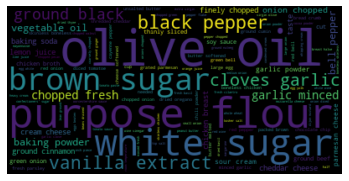

<Figure size 1440x1152 with 0 Axes>

In [17]:
text = []
for i in ingredients["INGREDIENT"]:
    text.append(i)

text = ' '.join(text).lower()

wordcloud = WordCloud(stopwords = STOPWORDS, collocations = True).generate(text)

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.figure(figsize=(20,16))
plt.show()